# Импорт необходимых библиотек

In [321]:
import numpy as np
import pandas as pd
import pandas_profiling

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:,.2f}'.format

import matplotlib
import seaborn as sns
%matplotlib inline

from IPython.display import display, Math, Latex

In [2]:
def get_std(df,f_list):
    z = df[f_list].apply(np.std,axis = 1)
    return StandardScaler().fit_transform(np.array(z).reshape(-1, 1))

# Чтение исходных данных, смысловое описание параметров

In [359]:
df = pd.read_excel(r"for_clustering.xlsx")

In [4]:
df.shape

(27508, 45)

In [5]:
df.head()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,0.042788,1,1,22,3,557.97,1,1,1,1


   У нас есть какой-то магазин, в котором побывало 27508 клиентов. Т.к. у нас есть довольно полная информация по ним, то предположу, что это все владельцы карт постоянного покупателя. + 
 
 ### Соответственно сначала надо попытаться разобраться что значат все показатели :
  
- **InWeek_amount** - Количество недель с даты регистрации клиентской карты (Можно разбить на старых и недавних клиентов)
- **InWeek_SKU** - Показатель в рамках от 0 до 50, SKU - единица товара на складе. Скорее всего это количество купленных товаров за последнюю неделю 
- **Checkinmonth_average** - Среднее количество посещений магазина за месяц
- **Checkamount_mean** - Средний чек
- **Count_transac** - количество транзакций?
- **Total_amount** - Общая сумма покупок
- **Total_SKU_qnt** - Итоговое количество купленных товаров
- **Сount_departments** - Из какого количества департаментов покупает
- **Count_shop** - Количество посещенных магазинов
- **Count_city** - количество посещенных городов в которых есть магазины
- **Tenure** - может быть стаж?
- **SKU_meanbytransac** - Среднее количество товаров в чеке
- **Amount_last6mnth** - Сумма за 6 месяцев
- **Check_qntlast6mnth** - количество за 6 месяцев
- **SKU_price_mean** - Средняя стоимость одной единицы товара
- **Gender** - Пол
- **Age** - возраст
- **Age_group** - Возрастная группа
- **Interval_visit** - Совокупное количество посещений
- **Days_pastvisit** - дней с последнего визита
- **Cat_householdchem_qnt** - По категориям все очевидно
- **Cat_householdchem_amount**
- **Cat_householdchem_share**
- **Cat_careproducts_qnt**
- **Cat_careproducts_amount**
- **Cat_careproducts_share**
- **Cat_toiletries_qnt**
- **Cat_toiletries_amount**
- **Cat_toiletries_share**
- **Cat_healthwellnes_qnt**
- **Cat_healthwellnes_amount**
- **Cat_healthwellnes_share**
- **Cat_babyprod_qnt**
- **Cat_babyprod_amount**
- **Cat_babyprod_share**
- **Communication_3month** - Была отправлена информация в последние 3 месяца
- **Response_communcation** - Был ответ на информацию
- **SKU_LastMonthqnt** - Сколько товаров купленов последний месяц
- **Checks_LastMonthqnt** - Количество чеков последний месяц
- **Amount_LastMonth** - Объем последний месяц
- **Discount** - скидка на аккаунте сейчас
- **Discount_LastMonth** - скидка на аккаунты в прошлом месяце
- **SEGMENT** - предположительно это верные метки кластеров

## Избавляемся от Nan

In [24]:
sum([True for idx,row in df.iterrows() if any(row.isnull())])

241

У нас  всего 241 покупатель с отсутствующими показателями, на оценку сильно не повлияет, что мы просто дропнем их из датасета, но в будущем можно будет поработать и предположить модель, прогнозирующую заменяющие значения

In [28]:
df.dropna(inplace = True)
df.shape

(27267, 44)

### Перекодировка категориальных признаков

In [30]:
Gender = {'M':1,
          'F':2,
         }
Age_group = {'0-25':0,
             '25-35':1,
             '35-45':2,
             '45-55':3,
             '55-65':4,
             '65+':5
              }

In [33]:
df['Gender_map'] = df['Gender'].map(Gender)
df['Age_map'] = df['Age_group'].map(Age_group)

In [36]:
df.drop(['Age_group','Gender'], axis = 1, inplace = True)

### Оценка параметров

In [40]:
df_col_x = list(df.columns)
[df_col_x.remove(i) for i in ['Id_client', '_SEGMENT_', 'EM_SEGMENT']]
df_x = df[df_col_x]

In [361]:
df.describe()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,"27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00",...,"27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00","27,508.00"
mean,"210,314.23",314.79,31.46,2.57,159.52,82.47,"9,595.76",764.24,26.74,3.86,...,0.06,1.00,0.55,40.34,8.40,936.14,1.00,0.92,2.00,2.00
std,"121,828.91",144.49,11.38,1.21,111.53,63.24,"4,715.29",451.73,4.04,2.76,...,0.05,0.01,0.50,23.77,7.22,590.93,0.04,0.27,0.78,0.78
min,"5,743.00",34.47,2.00,2.00,10.24,4.00,739.36,33.00,7.00,1.00,...,0.00,0.00,0.00,1.00,1.00,99.00,0.00,0.00,1.00,1.00
25%,"105,405.50",213.04,23.00,2.00,85.73,39.00,"5,897.18",433.00,24.00,2.00,...,0.02,1.00,0.00,22.00,3.00,446.88,1.00,1.00,1.00,1.00
50%,"211,786.00",289.22,31.00,2.00,128.75,66.00,"8,820.70",674.00,27.00,3.00,...,0.05,1.00,1.00,37.00,6.00,825.89,1.00,1.00,2.00,2.00
75%,"309,746.25",385.38,41.00,2.00,199.25,108.00,"12,631.30","1,003.00",30.00,5.00,...,0.08,1.00,1.00,55.00,11.00,"1,329.79",1.00,1.00,3.00,3.00
max,"830,188.00","2,180.01",51.00,20.00,"1,326.12",990.00,"22,748.39","5,058.00",38.00,46.00,...,0.89,1.00,1.00,180.00,112.00,"2,478.47",1.00,1.00,3.00,3.00


MemoryError: 

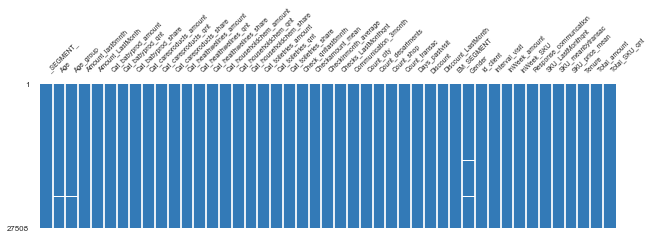

In [360]:
pandas_profiling.ProfileReport(df)

_Немного читерский способ, но очень эффективный_
### Исходя из данных делаем следующие выводы:
- Информация о скидках и о Communication_3month - бесполезная, отсутствует вариация
- Удаляем возраст, оставляем только перекодированную кем-то группировку
- покупают примерно столько же детских товаров как и товаровы по уходу за собой


In [99]:
df_x.drop(['Discount','Communication_3month','Count_city'],axis = 1,inplace = True)

In [100]:
df_x.corr().style.background_gradient(cmap='coolwarm')

,Count_transac,Count_departments,Count_shop,Tenure,SKU_price_mean,Interval_visit,Days_pastvisit,Cat_householdchem_share,Cat_careproducts_share,Cat_healthwellnes_share,Cat_babyprod_share,Response_communcation,Discount_LastMonth,Gender_map,Age_map,amount_collide,sku_collide,check_collide
Count_transac,1,0.334769,0.213321,0.421855,-0.320475,-0.309279,-0.6365,0.0625657,0.0553716,-0.180819,-0.189808,-0.335027,0.137568,-0.00818571,-0.0348428,0.487455,0.627169,0.627169
Count_departments,0.334769,1,0.250229,0.370411,-0.108412,-0.143479,-0.370075,-0.0074468,0.0540685,0.178773,0.102432,-0.182345,0.156205,0.0732408,-0.277216,0.566536,0.468773,0.468773
Count_shop,0.213321,0.250229,1,0.26871,-0.0045722,-0.0707521,-0.190229,-0.0348717,0.0650506,-0.0012466,0.00486523,-0.177894,0.038844,-0.0780515,-0.153308,0.16518,0.103601,0.103601
Tenure,0.421855,0.370411,0.26871,1,-0.249491,-0.13941,-0.339221,0.0383216,0.0541871,-0.0862945,-0.0799557,-0.249642,0.112236,0.0471169,0.0604182,0.501629,0.51939,0.51939
SKU_price_mean,-0.320475,-0.108412,-0.0045722,-0.249491,1,0.203666,0.279598,-0.12151,0.0775667,0.191677,0.244086,0.139929,-0.212891,-0.105195,-0.094533,0.0461261,-0.445224,-0.445224
Interval_visit,-0.309279,-0.143479,-0.0707521,-0.13941,0.203666,1,0.354271,-0.0527366,-0.0652587,0.0563459,0.261066,0.177122,-0.206912,-0.0265989,-0.0305564,-0.16605,-0.232492,-0.232492
Days_pastvisit,-0.6365,-0.370075,-0.190229,-0.339221,0.279598,0.354271,1,-0.0496002,-0.114962,0.17483,0.207033,0.268257,-0.1437,0.0072516,0.0257597,-0.414595,-0.458392,-0.458392
Cat_householdchem_share,0.0625657,-0.0074468,-0.0348717,0.0383216,-0.12151,-0.0527366,-0.0496002,1,-0.235675,-0.235457,-0.241771,-0.0222492,0.0416245,0.0603644,0.0875764,0.00417554,0.0657726,0.0657726
Cat_careproducts_share,0.0553716,0.0540685,0.0650506,0.0541871,0.0775667,-0.0652587,-0.114962,-0.235675,1,-0.226083,-0.25081,-0.0330999,-0.0330752,0.0558623,-0.0677609,0.104864,0.0324036,0.0324036
Cat_healthwellnes_share,-0.180819,0.178773,-0.0012466,-0.0862945,0.191677,0.0563459,0.17483,-0.235457,-0.226083,1,0.817687,0.0655282,-0.0147779,0.117453,-0.119261,-0.0257985,-0.144649,-0.144649


Странная ситуация в практически полной взаимосвязи (ρ = 0.99995) количества детской продукции от количества товаров по уходу за собой, нет смысла включать оба показателя 

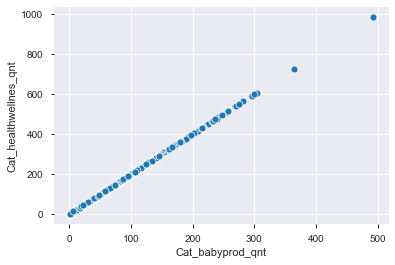

In [47]:
sns.scatterplot(x='Cat_babyprod_qnt', y='Cat_healthwellnes_qnt', data=df_x)

In [48]:
df_x.drop('Cat_healthwellnes_qnt',axis = 1,inplace = True)

Текущей задачей является минимизировать размерность и обработать факторы, вот несколько идей как это можно сделать:

     У каждого клиента у нас есть несколько характеристик разбитые по времени, которые нам нужны для того, чтобы определить является ли клиент постоянным, часто ли он использует наш магазин и в  каком объеме. Если предположить, что этот интересующий нас критерий, то все характеристики, разитые на временные промежутки можно переконвертировать в оценку по этому параметру. Логика должна быть такой, что чем больше этот коэф., тем сильнее возрастает объем данного параметра во времени. 

    Получается у тех, кто просто  забежал пару раз в магазин - оценка по этому коэф должна быть мнимальна и чем больше посещал - тем больше она должна быть

Данной операцией мы избежим излишней взаимосвязи признаков (признаки из которых происходила конвертация будут удалены) и сократим пространство по которому необходимо производить кластеризацию

Самым простым решением будут вывести нормализированное среднекватратическое отклонение(С точки зрения статистики, скорее всего, было бы правильно сначала разделить все промежукти в соответствии с их временными интервалами, чтобы получить оценку на на 1, например сумму за 30 дней разделить на 30, но я хочу узнать была ли вариативность вообще)


In [49]:
amount_collide = ['InWeek_amount','Total_amount',
                  'Amount_last6mnth', 'Amount_LastMonth']
sku_collide = ['InWeek_SKU','Total_SKU_qnt',
               'SKU_meanbytransac', 'SKU_LastMonthqnt']
check_collide = ['Checkamount_mean','Check_qntlast6mnth',
                 'Checks_LastMonthqnt','Checkinmonth_average']

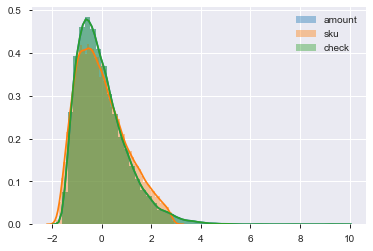

In [50]:
amount = get_std(df_x,amount_collide)
sku = get_std(df_x,sku_collide)
check = get_std(df_x,sku_collide)
f, ax = plt.subplots(1, 1)
sns.distplot(sku)
sns.distplot(amount)
sns.distplot(check)
plt.legend(labels=['amount', 'sku', 'check'])

In [51]:
df_x['amount_collide'], df_x['sku_collide'], df_x['check_collide'] = amount,sku,check

In [52]:
df_x.drop(amount_collide + sku_collide + check_collide,axis = 1,inplace = True)

In [53]:
df_x.shape

(27267, 31)

## Следущей идеей является оптимизация категорий товара. 

    У нас есть 5 категорий, причем у каждой из категорий у естьтри параметра: 
     - 1. - Сумма, потраченная на данную категрию за все время
     - 2. - Количество товаров, купленных в данной категории
     - 3. - Доля от всех категорий (причем сумма долей по пяти категориям всегда равна 1)

Собственно, у нас уже есть мера учетa изменчивости общего объема и сумм, нам нет смысла дублировать долевое количество или сумм, а только оставить долю. Благодаря агрегатам выше мы уже и так понимаем - сколько и за сколько покупает клиент, но вот что именно - еще нет, тут помоагет как раз структурная доля.

In [54]:
df_x.drop(['Cat_householdchem_qnt', 'Cat_householdchem_amount',
        'Cat_careproducts_qnt',
       'Cat_careproducts_amount', 
       'Cat_toiletries_qnt', 'Cat_toiletries_amount', 'Cat_toiletries_share',
        'Cat_healthwellnes_amount',
        'Cat_babyprod_qnt', 'Cat_babyprod_amount'],axis = 1,inplace = True)

In [101]:
df_x.shape

(27267, 18)

### Станадртизация данных

Для того, чтобы использвать кластеризационные метрики и алгоритма, основаные на мере рассстояния - необходимо осущестивить преобразование. Оно преобразует ваши данные таким образом, что его распределение будет иметь среднее значение 0 и стандартное отклонение 1.

In [102]:
scaler = StandardScaler()

In [103]:
sc = scaler.fit_transform(df_x)

In [104]:
df_sc = pd.DataFrame(sc,columns = df_x.columns)

In [105]:
df_sc.head(3)

,Count_transac,Count_departments,Count_shop,Tenure,SKU_price_mean,Interval_visit,Days_pastvisit,Cat_householdchem_share,Cat_careproducts_share,Cat_healthwellnes_share,Cat_babyprod_share,Response_communcation,Discount_LastMonth,Gender_map,Age_map,amount_collide,sku_collide,check_collide
0,0.587046,-0.183048,0.051558,1.004154,-0.578183,-0.783864,-0.506027,-0.102780,-0.397000,0.189829,0.457476,0.908956,0.292869,0.67219,-0.240037,0.610437,0.764611,0.764611
1,0.762221,0.560129,-0.310768,0.061583,-0.231497,-0.783864,-0.725633,1.001723,-0.141743,0.105860,-0.446387,-1.100164,0.292869,0.67219,-0.950379,0.654492,0.551047,0.551047
2,-0.846203,-0.678500,-1.035418,-1.823559,0.471205,2.042607,0.592002,-2.212983,3.076349,0.754606,1.110557,0.908956,0.292869,0.67219,-0.950379,-1.438880,-1.296984,-1.296984


### Снижение размерности (Dimensionality  reduction)

Большинство метрик формирования кластеров основаны на растояниях относительно расположения на опередленных точках осей координат. Соответственно, кластеризуем по двум признакам - 2D, трем - 3D и так далее у нас 18 признаков. Одним из методов снижения размерности на основании вклада в изменение вариативности является метод главных компонент (PCA). 

Данный метод, путем оценки максимальной выборочной дисперсии каждой компоненты находит такую аппрокисмиацию (выраженную линейно), которая объяснят какую-то (наибольшую для каждого количетсва компонент) часть дисперсии общей выборки

In [170]:
com = list(range(2,19))
variance = {}
for i in com:
    pca = PCA(n_components = i)
    pca_result = pca.fit_transform(df_sc.values)
    variance.update({i:sum(pca.explained_variance_ratio_)})

In [151]:
variance

{2: 0.3922324735684205,
 3: 0.4745541585568369,
 4: 0.5417365685224859,
 5: 0.6048805768375991,
 6: 0.6601508037597524,
 7: 0.7128966431974271,
 8: 0.7614798822250689,
 9: 0.8097117768420762,
 10: 0.8525638366796537,
 11: 0.8870380294495802,
 12: 0.9168150260337893,
 13: 0.9451011792828607,
 14: 0.9703700636300933,
 15: 0.9868802741685163,
 16: 0.9951502428066599,
 17: 0.9999999999999999,
 18: 0.9999999999999999}

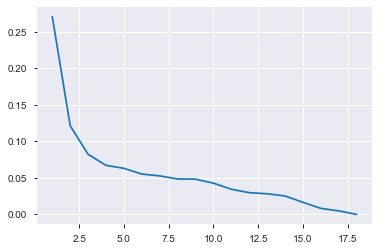

In [174]:
sns.lineplot(y = pca.explained_variance_ratio_, x = list(range(1,19)))

Стоит выбрать 8 главных компонент, объясняющих 76+% выборки. Теперь их необходимо интерпретировать с точки зрения логики и как-то назвать для упрощения в будущем каких-то выводов для бизнеса

In [175]:
pca = PCA(n_components = 8)
pca_result = pca.fit_transform(df_sc.values)

In [178]:
pca_df = pd.DataFrame(pca_result,columns = ['PCA_{}'.format(i) for i in range(1,9)])

In [180]:
pca_df.head(3)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8
0,1.481949,0.498657,-0.839990,-0.022778,-0.502160,-0.161908,-0.244663,0.074105
1,1.827477,-0.035325,-0.229833,-0.885628,0.112498,-0.950263,-0.109569,-1.097747
2,-3.636357,0.941869,1.882374,0.569939,-3.054188,-0.305566,-0.422600,0.689160


In [185]:
pd.DataFrame(pca.components_, index = ['PCA_{}'.format(i) for i in range(1,9)], columns = df_sc.columns).T.style.background_gradient(cmap='coolwarm')

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8
Count_transac,0.352592,-0.02044,0.0392247,-0.0903102,0.0515956,0.112085,0.0532386,-0.205982
Count_departments,0.264091,0.320179,0.0986404,-0.0728837,0.0220336,-0.30852,-0.161637,0.0264009
Count_shop,0.122129,0.131329,0.339069,-0.285951,0.295087,-0.0252622,0.380049,0.42684
Tenure,0.29484,0.081547,-0.00569484,0.109399,0.0706636,0.0112779,0.302481,0.294243
SKU_price_mean,-0.204646,0.20249,0.338126,0.215503,0.12244,-0.0120047,-0.0612803,-0.229376
Interval_visit,-0.180467,0.125405,-0.00281943,0.443601,0.224121,-0.190774,0.155126,0.389927
Days_pastvisit,-0.310833,0.0425667,-0.111526,0.204639,0.0266533,-0.0863857,0.000809221,0.285771
Cat_householdchem_share,0.0480156,-0.2448,-0.308586,-0.0767914,0.461074,-0.474767,0.0299414,-0.162098
Cat_careproducts_share,0.0517665,-0.115387,0.523487,0.162368,-0.51586,-0.0918807,0.0632012,0.0693355
Cat_healthwellnes_share,-0.106635,0.56416,-0.200551,-0.155627,-0.102253,0.122454,0.0163893,-0.11901


 - PCA_1 - "Шопоголизм" - Надо покупать много и всего 
 - PCA_2 - "Здоровье" - приоретизация медикаментов и товаров заботы о себе, ниже среднего возраста
 - PCA_3 - "Красота" - покупка товаров заботы о себе приоретезируются над остальными, существенно ниже среднего возраста
 - PCA_4 - "Лояльность" - постоянство клиента в выборе этого магазина 
 - PCA_5 - "Химия+возраст" - Мало товаров заботы о себе, много возраста и химии
 - PCA_6 - "Возрастная_харакетристика" -  Мало покупают товаров для дома
 - PCA_7 - "Глухость к рекламе"
 - PCA_8 - "Грамотность в покупке" - важна стоимость, скидки

### Процесс кластеризации

In [188]:
from sklearn import mixture

In [208]:
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

In [210]:
clf.fit(pca_df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Таблица принадлежности(вероятности принадлежности) каждого из клиентов к одному из трех кластеров:

In [332]:
pd.DataFrame(clf.predict_proba(pca_df)).head().style.background_gradient(cmap='PiYG')

,0,1,2
0,0.00124958,0.220938,0.777812
1,0.00114179,0.709812,0.289046
2,0.0847231,0.910268,0.00500878
3,1.27805e-07,0.000206444,0.999793
4,0.0731519,0.061671,0.865177


In [335]:
cluster = clf.predict(pca_df)

### Интерепретация результатов кластеризации

Мы имеем 28 разичных сочетаний PCA, которые разбиты относительно кластеров. 

In [325]:
display(Math(r'C_{8}^{2} = \frac{8!}{2! \cdot (8-2)!} = \frac{8!}{2! \cdot 6!} = \frac{7 \cdot 8}{1 \cdot 2} = 28'))

<IPython.core.display.Math object>

Лучшим вариантом было бы пееребрать эти 28 графиков и понять как наши данные кластеризовались и как их можно описать для бизнес-нужд.Либю уменьшить количество PCA и сделать все проще, но менее качественно (мы и так потеряли вариативность на методе главных компонент)

In [355]:
pca_df['cluster'] = cluster
df['cluster'] = cluster

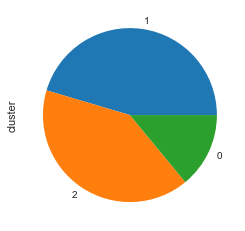

In [351]:
pca_df['cluster'].value_counts().plot(kind='pie')

на основе анализа точечных графиков (как ниже) можно сделать предположения

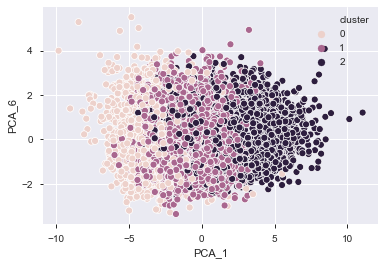

In [352]:
sns.scatterplot(x="PCA_1", y="PCA_6", hue="cluster",data=pca_df)

0 - кластер слабо заинтересованных в покупке товаров, глухих к рекламе, забегающих иногда в этот магазин, мало покупают, нечасто, нет яркой характеристики возраста

1 - Средний покупатель, лоялен к магазину, покупает в основном какую-то одну категорию

2 - VIP клиент - Большинство характеристик выше среднего, часто бывают и часто покупают, покупают из разных категорий, возраст выше среднего

P.S. аналитику можно существенно улучшить разнообразными методами работы с фичами, подгонки модели ближе к бизнес задаче (непонятно мы хотим понять кому дать рекламу, понять наших випов и тд) + я делал довольно грубые предположения по законам распределения и того, что некоторые показатели можно просто отбросить или переконвертировать 
+ до сих пор непонятно что такое Tenure 😒